In [1]:
# Local imports
import argparse
import glob
import os
import sys
import re

# Third-party imports
import xarray as xr
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import pandas as pd
from datetime import datetime
import cftime

In [2]:
# Import the dictionaries
import dictionaries as dic

# Import the functions
import processing_NAO_data as pnd
import functions_lag as fnc_lag
import functions_skill_maps as fnc_sm

In [ ]:
# make the saved data directory if it doesn't exist
if not os.path.exists(dic.saved_data_dir):
    os.makedirs(dic.saved_data_dir)

# define the paths to the processed data files
azores_data_path = dic.azores_data_path
iceland_data_path = dic.iceland_data_path

In [3]:
# First thing to do is to process the observations
# We need to set up the parameters for this
forecast_range = "2-6"
season = "DJFM"
variable = "psl"
obs_var_name = "psl"
region_grid = "north-atlantic"
models = dic.models # all models for psl
observations_path = dic.full_era5 # contains all months and variables

In [4]:
# Check if the processed data files exist
if os.path.exists(azores_data_path) and os.path.exists(iceland_data_path):
    # If the files exist, load the processed data from the files
    obs_azores = np.load(azores_data_path)
    obs_iceland = np.load(iceland_data_path)
else:
    # If the files don't exist, process the observations and save the processed data to files
    # Process the observations for the Azores region
    region = "azores"
    obs_azores = fnc_sm.process_observations(variable, region, region_grid,
                                                forecast_range, season, 
                                                observations_path, obs_var_name)
    
    # Now do the same but for the iceland region
    region = "iceland"
    obs_iceland = fnc_sm.process_observations(variable, region, region_grid,
                                            forecast_range, season, 
                                            observations_path, obs_var_name)

    # Save the processed data to files
    np.save(azores_data_path, obs_azores)
    np.save(iceland_data_path, obs_iceland)

File already exists
Forecast range: 2 - 6
Rolling mean range: 5


In [6]:
# Now we have obs anomaly fields for year 2-6 DJFM psl
# for both the azores and iceland gridboxes
# we want to take the fieldmean of these
# then subtract iceland from azores
# use the calculate_nao_index function from functions_skill_maps.py for this
obs_nao_index = fnc_sm.calculate_nao_index(obs_azores, obs_iceland)

In [7]:
# obs_nao_index.values

In [8]:
# obs_nao_index.time

In [9]:
# Now we want to load all of the same init files
# There should be 158 of them (we are missing CanESM5)
# These contain year 2-6 running means
# We will use them for our no lag case
# Set up the models to be included to be the no_CanESM5 models
models = dic.models_no_can

# Set up the base directory
base_dir = dic.base_directory

# Use the function: load_data_same_init from functions_lag.py
# to load the same init files
same_init_members = fnc_lag.load_data_same_init(base_dir, models, 
                                                variable, forecast_range, season)

Searching for files in  /home/users/benhutch/alternate-lag-processed-data/*BCC-CSM2-MR*same-init.nc
Files for BCC-CSM2-MR: ['/home/users/benhutch/alternate-lag-processed-data/NAO_BCC-CSM2-MR_psl__DJFM_lag-4_r1i1.same-init.nc', '/home/users/benhutch/alternate-lag-processed-data/NAO_BCC-CSM2-MR_psl__DJFM_lag-4_r2i1.same-init.nc', '/home/users/benhutch/alternate-lag-processed-data/NAO_BCC-CSM2-MR_psl__DJFM_lag-4_r3i1.same-init.nc', '/home/users/benhutch/alternate-lag-processed-data/NAO_BCC-CSM2-MR_psl__DJFM_lag-4_r4i1.same-init.nc', '/home/users/benhutch/alternate-lag-processed-data/NAO_BCC-CSM2-MR_psl__DJFM_lag-4_r5i1.same-init.nc', '/home/users/benhutch/alternate-lag-processed-data/NAO_BCC-CSM2-MR_psl__DJFM_lag-4_r6i1.same-init.nc', '/home/users/benhutch/alternate-lag-processed-data/NAO_BCC-CSM2-MR_psl__DJFM_lag-4_r7i1.same-init.nc', '/home/users/benhutch/alternate-lag-processed-data/NAO_BCC-CSM2-MR_psl__DJFM_lag-4_r8i1.same-init.nc']
Searching for files in  /home/users/benhutch/alterna

In [10]:
# Now we want to process the same init model data before it is plotted
# by extracting the data for out variable of interest (e.g. temperature)
# and the time values
# the function used for this is: process_data from functions_lag.py
processed_same_init_members, same_init_members_time = fnc_lag.process_data(
    same_init_members, variable)

Dataset type: <class 'dict'>


In [15]:
# test
processed_same_init_members['NorCPM1'].time

AttributeError: 'list' object has no attribute 'time'

obs_time type: <class 'numpy.ndarray'>
model_time type: <class 'list'>
obs_time: ['1959-12-31T00:00:00.000000000' '1960-12-31T00:00:00.000000000'
 '1961-12-31T00:00:00.000000000' '1962-12-31T00:00:00.000000000'
 '1963-12-31T00:00:00.000000000' '1964-12-31T00:00:00.000000000'
 '1965-12-31T00:00:00.000000000' '1966-12-31T00:00:00.000000000'
 '1967-12-31T00:00:00.000000000' '1968-12-31T00:00:00.000000000'
 '1969-12-31T00:00:00.000000000' '1970-12-31T00:00:00.000000000'
 '1971-12-31T00:00:00.000000000' '1972-12-31T00:00:00.000000000'
 '1973-12-31T00:00:00.000000000' '1974-12-31T00:00:00.000000000'
 '1975-12-31T00:00:00.000000000' '1976-12-31T00:00:00.000000000'
 '1977-12-31T00:00:00.000000000' '1978-12-31T00:00:00.000000000'
 '1979-12-31T00:00:00.000000000' '1980-12-31T00:00:00.000000000'
 '1981-12-31T00:00:00.000000000' '1982-12-31T00:00:00.000000000'
 '1983-12-31T00:00:00.000000000' '1984-12-31T00:00:00.000000000'
 '1985-12-31T00:00:00.000000000' '1986-12-31T00:00:00.000000000'
 '1987-12

IndexError: index 0 is out of bounds for axis 0 with size 0

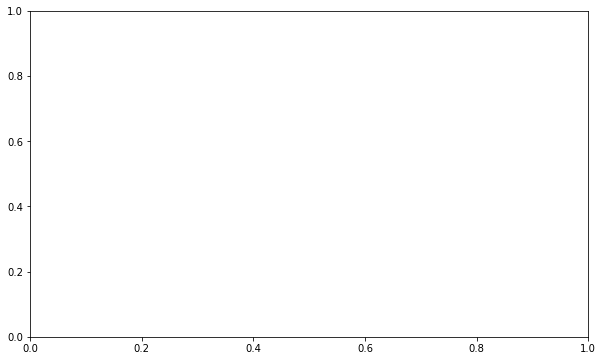

In [12]:
# Now we want to plot the no lag case for the 158 members
# Using the plot_ensemble_members_and_mean function
# from processing_NAO_data.py (pnd.)

# Set up the arguments for the function
models = dic.models_no_can
model_times = same_init_members_time
model_nao_anoms = processed_same_init_members
obs_nao_anom = obs_nao_index.values
obs_time = obs_nao_index.time.values

# Run the function
pnd.plot_ensemble_members_and_mean(models, model_times, model_nao_anoms,
                                    obs_nao_anom, obs_time) 